## Exercise: Image segmentation using flows
<font color='blue'><b>Goal:</b></font>
Implement an image segmentation procedure using minimum $s$-$t$ cuts.

<font color='blue'><b>Python packages required:</b></font>
`networkx`, `numpy`, `matplotlib`, `PIL`

Image segmentation is one of the very classical image processing problems. It is about splitting an image into different content-related parts, e.g., the separation of foreground and background. The aim is to do this with a rough manual preselection to outline the part of the image that should be separated. The following figure from the script shows the extraction of the foreground on the example of the Mona Lisa by Leonardo da Vinci.

![](07_imageSegmentation_monaLisa.png)

In this exercise, we implement an image segmentation algorithm based on the approach seen in class, which models image segmentation as a minimum $s$-$t$ cut problem in a suitable auxiliary graph.

For your convenience, we created a module of helper functions (the file `imageSegmentation_module`) which you can use without having to understand how they work. The helpers are explained below.

In [73]:
import imageSegmentation_module as helpers

### Dealing with pictures in Python

For simplicity, we will deal with grayscale images that we represent by an array of numbers from $0$ to $255$, where every array entry corresponds to one pixel of the image, and a $0$ indicates a black pixel, while $255$ indicates a white pixel.

The module of helper functions provides the function `read_image` to read an image file and output it as the grayscale array discussed above. Furthermore, there is a function `plot_image` to plot grayscale arrays.

The following code cells process a small image of the skyscraper Taipei 101 of size $140\times 150$ pixels and plots it.

In [74]:
img = helpers.read_image("07_imageSegmentation_picture.jpeg")
print(img)

[[239 241 243 ... 239 239 239]
 [239 241 243 ... 238 238 238]
 [239 241 242 ... 237 237 237]
 ...
 [  8  13  28 ...  13   8  23]
 [  6   9  26 ...  21  14  24]
 [  3   5  24 ...  21   6  13]]


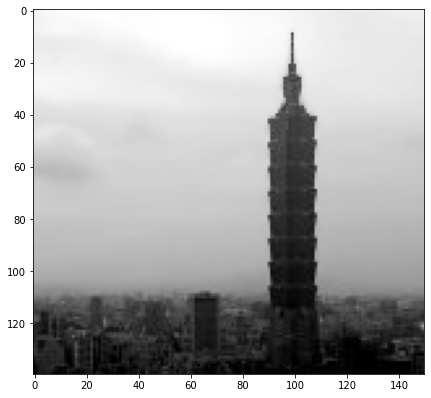

In [75]:
helpers.plot_image(img)

### Defining a selection

For the image segmentation, we provide a rough manual preselection of an area that we would like to cut and which is later refined using the image segmentation procedure. We represent such a preselection by a $0$-$1$ array of the same shape as the image, where a $0$ indicates that the corresponding pixel is not included in the preselection, and a $1$ indicates that it is.

While a preselection can be constructed manually, the helper function module provides a function `polygonal_selection` for constructing a preselection array by indicating corner points of a polygon (note that the polygon does not necessarily have to be convex). It takes the corner points of the polygon and the desired shape of the picture as arguments.

In [76]:
# Corners of polygon comprising the skyscraper approximately (manual 
#   selection).
#   Note: In the tuples, the horizontal coordinate is first, and the
#         vertical coordinate is second (measured from top to bottom,
#         as in the picture plot above.)

xy = [(89,120), (90,40), (99, 8), (108,38), (110,120)]

sel = helpers.polygonal_selection(xy, img.shape)

sel

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

For plotting a selection, you can use the function `plot_selection` that is provided among the helper functions. It takes two arrays of the same size, namely the image array and the binary array indicating the selection.

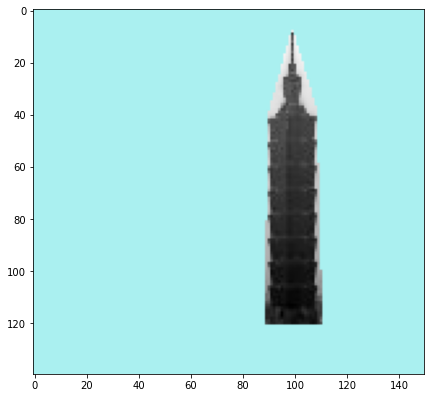

In [77]:
helpers.plot_selection(img, sel)

### Modelling image segmentation as minimum cuts

As seen in class (see section 4.4.7), we model image segmentation as a minimum $s$-$t$ cut problem in a suitable digraph, which has a vertex for every pixel of the image, and two additional vertices $s$ and $t$.

The edges and their capacities are constructed following two ideas, which we repeate here once more.

1. An $s$-$t$ cut should incur penalties for not including pixels that are in the preselection, and for including pixels that are not in the preselection. This is achieved by adding arcs $(s,p)$ for pixels $p$ in the preselection, and arcs $(p,t)$ for pixels $p$ not in the preselection, and putting a non-negative capacity $x\in\mathbb{Z}_{\geq 0}$ on these arcs (cf. Figure 4.17 from the script).

  ![](07_imageSegmentation_figPreselection.png)

2. There should be less incentive to cut adjacent pixels of similar colors apart, while cutting at totally different colors should be beneficial in terms of the cut value. To this end, we introduce arcs connecting adjacent pixels (in both directions), and assign capacities depending on the pixels colors. In the script, where we discussed an example with colors instead of grayscale, we defined a capacity function $u$ with the desired properties, exemplified in the following figure (Figure 4.18 from the script).

  ![](07_imageSegmentation_figColors.png)

  For the grayscale example that we do here, where every pixel $p$ has a grayscale value $g_p\in\{0,1,\ldots,255\}$, we can simply use the capacity function
  
  $$ u(p,q) := 255 - |g_{p} - g_{q}|\qquad\text{for adjacent pixels $p,q$}\enspace. $$

### Implementation

<font color='blue'><b>Your first task:</b></font> Complete the following function `get_digraph(img, sel, x)` that, given an image array `img`, a selection array `sel` of the same size, and a capacity `x`$\in\mathbb{Z}_{\geq 0}$, constructs the capacitated digraph $G$ discussed above and returns it together with the vertices $s$ and $t$. Make sure that the vertices can be uniquely associated to the coordinates of the corresponding pixels, and use the edge attribute labelled "`capacity`" (the default capacity attribute used  for min-cut computations).

In [78]:
import networkx as nx
from math import pow

def get_digraph(img, sel, x, a):
    
    ## Your code goes here.
    h, w = img.shape
    G = nx.DiGraph()
    G.add_node('s')
    G.add_node('t')
    s = 's'
    t = 't'
    for i in range(h):
        for j in range(w):
            G.add_node((i, j), val=img[i][j])
            if sel[i][j] == 1:
                G.add_edge('s', (i, j), capacity=x)
            else:
                G.add_edge((i, j), 't', capacity=x)

    for i in range(h - 1):
        for j in range(w - 1):
            u_h = pow(255 - abs(img[i + 1][j] - img[i][j]), a)
            G.add_edge((i + 1, j), (i, j), capacity=u_h)
            G.add_edge((i, j), (i + 1, j), capacity=u_h)
            u_w = pow(255 - abs(img[i][j + 1] - img[i][j]), a)
            G.add_edge((i, j + 1), (i, j), capacity=u_w)
            G.add_edge((i, j), (i, j + 1), capacity=u_w)


    return (G, s, t)

<font color='blue'><b>Your second task:</b></font> Write a function `image_segmentation(img, sel, x)` that takes an image array `img`, a binary preselsection array `sel` of the same size, and the capacity parameter `x` as discussed above. It should return a $0$/$1$ array (of the same size as the input image), where a $1$ indicates that the corresponding pixel is contained in the segmented image, and a $0$ indicates that the corresponding pixels is not contained in the segmented image.

Use the `get_digraph` function you wrote above to get the auxiliary graph $G$. Moreover, you can use the minimum $s$-$t$ cut algorithm that `networkx` provides, namely `networkx.minimum_cut(G, s, t)`, to calculate a minimum $s$-$t$ cut in the auxiliary graph $G$. Note that this min-cut function returns a tuple consisting of the min-cut value and a partition, which is a tuple containing vertex sets consisting of the minimum $s$-$t$ cut and its complement.

In [79]:
def image_segmentation(img, sel, x, a=1):
    
    ## Your code goes here.
    G, s, t = get_digraph(img, sel, x, a)
    min_cut_val, vertex_set = nx.minimum_cut(G, s, t)
    cons = vertex_set[0] if s in vertex_set[0] else vertex_set[1]
    binary_segmentation_array = 0 * sel
    for each in cons:
        if each != s:
            binary_segmentation_array[each[0]][each[1]] = 1
        
    return binary_segmentation_array

<font color='blue'><b>Your third task:</b></font> Apply the function `image_segmentation` to the picture provided earlier. Try to explain what happens for small and large parameters `x` and try to find a sweetspot where it works somewhat well.

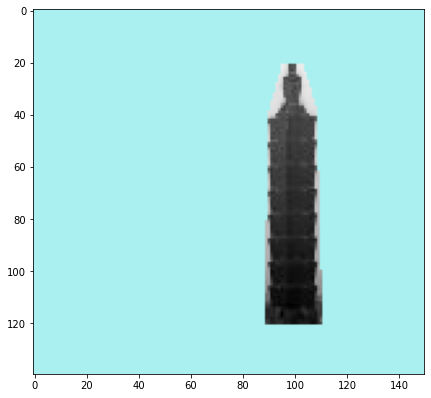

In [80]:
# testing

seg = image_segmentation(img, sel, 75)

helpers.plot_selection(img, seg)

<font color='blue'><b>Your fourth task:</b></font> You probably observed in the previous task that the image segmentation procedure does not really perform as well as we hoped. One way to improve it is to change the capacity function $u$ to $u(p,q) := (255- |g_p-g_q|)^a$ for some parameter $a\in\mathbb{Z}_{\geq 1}$. Change the functions you implemented above to do this change and test the parameters! You can set the extra parameter $a$ to $1$ by default in order not to mess up the tests you did above.

*Note: The order of magnitude of the capacities $u(p,q)$ changes considerably with this approach. You'll have to change the order of magnitude of the capacity `x` in about the same order.*

You can also play with your own pictures - just make sure that they are not too large in order not to blow up running times too much. Note that the helper function `read_image()` automatically convertes pictures to grayscale.

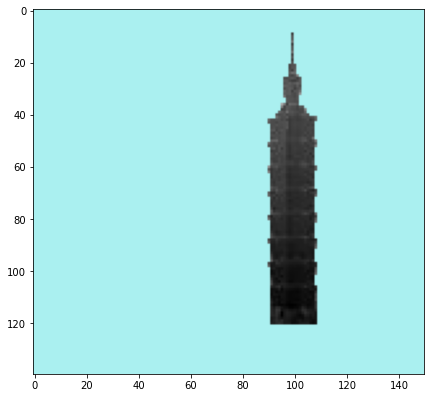

In [81]:
# your code goes here

seg = image_segmentation(img, sel, pow(170,5), a=5)

helpers.plot_selection(img, seg)